In [1]:
!pip install memory-profiler

## Import Libraries and Setup

In [2]:
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                   cross_val_score, StratifiedKFold)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, accuracy_score, 
                           confusion_matrix, precision_recall_fscore_support,
                           roc_auc_score, f1_score)

# Model persistence
import joblib
import pickle

# Performance monitoring
import psutil
import gc
from memory_profiler import memory_usage

# Set random seed for reproducibility
RANDOM_STATE = 331
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")

Libraries imported successfully!
XGBoost version: 2.0.3


## Data Loading and Initial Exploration

In [3]:
# Load the dataset
df = pd.read_csv('/kaggle/input/luflow-modified-dataset/luflow_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Available columns: {df.columns.tolist()}")

# Check target distribution
print(f"\nTarget distribution:")
print(df['label'].value_counts())
print(f"\nTarget distribution (%):")
print(df['label'].value_counts(normalize=True) * 100)

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum().sum())

Dataset shape: (7890694, 17)
Memory usage: 1889.78 MB
Available columns: ['avg_ipt', 'bytes_in', 'bytes_out', 'dest_ip', 'dest_port', 'entropy', 'num_pkts_out', 'num_pkts_in', 'proto', 'src_ip', 'src_port', 'time_end', 'time_start', 'total_entropy', 'label', 'duration', 'source_file']

Target distribution:
label
benign       4243325
malicious    2628641
outlier      1018728
Name: count, dtype: int64

Target distribution (%):
label
benign       53.776322
malicious    33.313179
outlier      12.910499
Name: proportion, dtype: float64

Missing values:
242752


## Feature Selection and Data Preprocessing

In [4]:
# Define feature columns (based on Joy tool specification)
feature_columns = [
    'src_ip', 'src_port', 'dest_ip', 'dest_port', 'proto',
    'bytes_in', 'bytes_out', 'num_pkts_in', 'num_pkts_out', 
    'entropy', 'total_entropy', 'avg_ipt',
    'time_start', 'time_end', 'duration'
]

# Select features and target
available_features = [col for col in feature_columns if col in df.columns]
X = df[available_features].copy()
y = df['label'].copy()

print(f"Using {len(available_features)} features: {available_features}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Handle missing values by removing rows with NaN
print(f"\nMissing values per column:")
missing_counts = X.isnull().sum()
print(missing_counts[missing_counts > 0])

# Remove rows with missing values
valid_mask = ~X.isnull().any(axis=1)
X_clean = X[valid_mask].copy()
y_clean = y[valid_mask].copy()

print(f"\nAfter cleaning:")
print(f"X shape: {X_clean.shape}")
print(f"y shape: {y_clean.shape}")
print(f"Removed {len(X) - len(X_clean)} rows with missing values")

Using 15 features: ['src_ip', 'src_port', 'dest_ip', 'dest_port', 'proto', 'bytes_in', 'bytes_out', 'num_pkts_in', 'num_pkts_out', 'entropy', 'total_entropy', 'avg_ipt', 'time_start', 'time_end', 'duration']
Features shape: (7890694, 15)
Target shape: (7890694,)

Missing values per column:
src_port     121376
dest_port    121376
dtype: int64

After cleaning:
X shape: (7769318, 15)
y shape: (7769318,)
Removed 121376 rows with missing values


##  Label Encoding and Data Splitting

In [5]:
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_clean)

print(f"Label classes: {label_encoder.classes_}")
print(f"Encoded distribution: {np.bincount(y_encoded)}")

# Create class weights for imbalanced dataset
class_counts = np.bincount(y_encoded)
total_samples = len(y_encoded)
class_weights = {}

for i, count in enumerate(class_counts):
    class_weights[i] = total_samples / (len(class_counts) * count)

print(f"Class weights: {class_weights}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_encoded, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y_encoded
)

print(f"\nData split:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training distribution: {np.bincount(y_train)}")
print(f"Test distribution: {np.bincount(y_test)}")


Label classes: ['benign' 'malicious' 'outlier']
Encoded distribution: [4243278 2529308  996732]
Class weights: {0: 0.6103235910224752, 1: 1.0239056163451294, 2: 2.5982637927413452}

Data split:
Training set: (6215454, 15)
Test set: (1553864, 15)
Training distribution: [3394622 2023446  797386]
Test distribution: [848656 505862 199346]


## Hyperparameter Tuning with GridSearchCV

In [6]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Use a stratified sample for hyperparameter tuning (much faster)
print("Creating sample for hyperparameter tuning...")
sample_size = min(50000, len(X_train))  # Use max 50k samples for tuning
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, 
    train_size=sample_size,
    random_state=RANDOM_STATE, 
    stratify=y_train
)

print(f"Using {len(X_sample):,} samples for hyperparameter tuning")

# Parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': stats.randint(100, 301),
    'max_depth': stats.randint(6, 11),
    'learning_rate': stats.uniform(0.05, 0.1),  # 0.05 to 0.15
    'subsample': stats.uniform(0.8, 0.2),       # 0.8 to 1.0
    'colsample_bytree': stats.uniform(0.8, 0.2), # 0.8 to 1.0
    'reg_alpha': stats.uniform(0, 0.5),
    'reg_lambda': stats.uniform(1, 1)
}


xgb_base = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    use_label_encoder=False
)

# Setup cross-validation
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# RandomizedSearchCV - much faster than GridSearchCV
print("Starting RandomizedSearchCV...")
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,  # Try 50 random combinations
    scoring='f1_weighted',
    cv=cv_folds,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

# Perform search
start_time = time.time()
search.fit(X_sample, y_sample)
search_time = time.time() - start_time

print(f"\nHyperparameter search completed in {search_time:.2f} seconds")
print(f"Best cross-validation score: {search.best_score_:.4f}")
print(f"Best parameters: {search.best_params_}")

# Store the search object for later use
grid_search = search

Creating sample for hyperparameter tuning...
Using 50,000 samples for hyperparameter tuning
Starting RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Hyperparameter search completed in 353.46 seconds
Best cross-validation score: 0.9107
Best parameters: {'colsample_bytree': 0.9015124575111676, 'learning_rate': 0.1475258295989335, 'max_depth': 8, 'n_estimators': 288, 'reg_alpha': 0.021230083176348002, 'reg_lambda': 1.564661496157627, 'subsample': 0.9378752775642055}


## Train Optimal Model and Evaluate

In [7]:
# Get the best model
best_xgb = grid_search.best_estimator_

# Train on full training set with best parameters
print("Training final model with best parameters...")
start_time = time.time()
best_xgb.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

# Make predictions
print("Making predictions...")
start_time = time.time()
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)
inference_time = time.time() - start_time

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
precision, recall, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Calculate per-sample inference time
avg_inference_time = (inference_time / len(X_test)) * 1000  # in milliseconds

print(f"\n=== FINAL MODEL PERFORMANCE ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (weighted): {f1_weighted:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"Total inference time: {inference_time:.4f}s")
print(f"Average inference per sample: {avg_inference_time:.4f}ms")


Training final model with best parameters...
Training completed in 415.83 seconds
Making predictions...

=== FINAL MODEL PERFORMANCE ===
Accuracy: 0.9540
F1-Score (weighted): 0.9531
Precision (weighted): 0.9533
Recall (weighted): 0.9540
Total inference time: 43.4760s
Average inference per sample: 0.0280ms


## Detailed Performance Analysis

Detailed Classification Report:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00    848656
   malicious       0.91      0.95      0.93    505862
     outlier       0.86      0.76      0.81    199346

    accuracy                           0.95   1553864
   macro avg       0.92      0.91      0.91   1553864
weighted avg       0.95      0.95      0.95   1553864



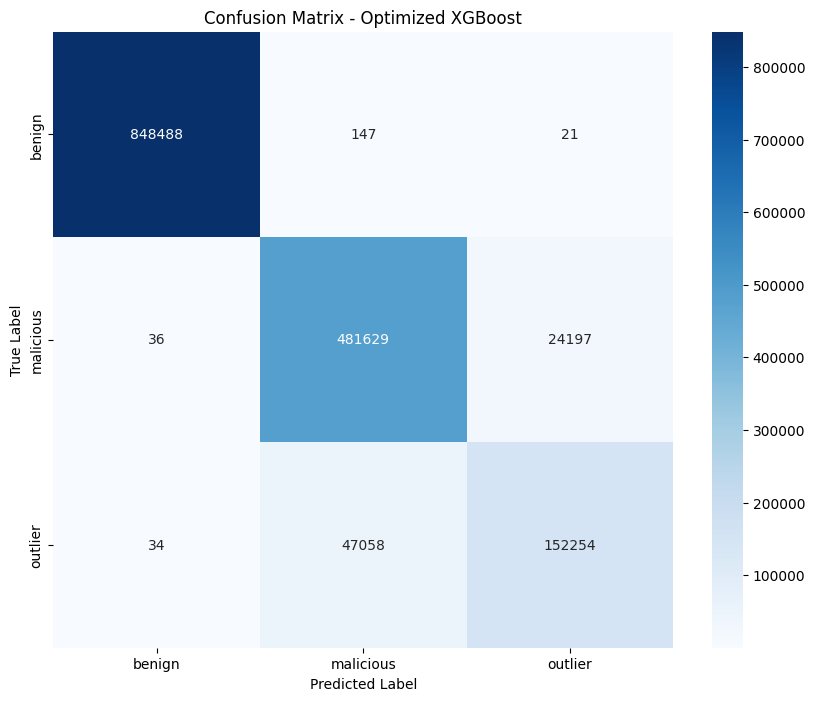


Top 10 Most Important Features:
          feature  importance
3       dest_port    0.528333
1        src_port    0.106270
2         dest_ip    0.071290
0          src_ip    0.065919
10  total_entropy    0.034550
7     num_pkts_in    0.034183
6       bytes_out    0.032427
4           proto    0.031350
13       time_end    0.020248
14       duration    0.019946


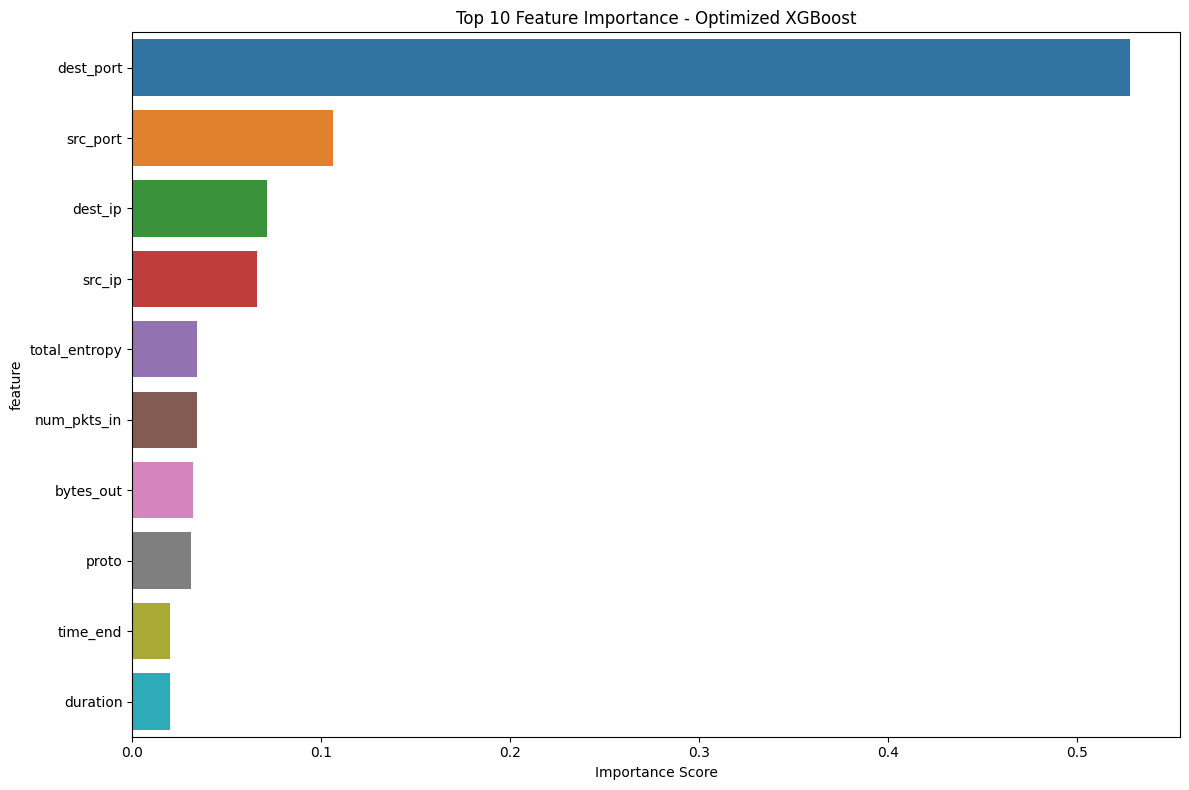

In [8]:
# Detailed classification report
print("Detailed Classification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Optimized XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance - Optimized XGBoost')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


## Cross-Validation Analysis

Top 10 Parameter Combinations:
Score: 0.9107 (±0.0010)
Params: {'colsample_bytree': 0.9015124575111676, 'learning_rate': 0.1475258295989335, 'max_depth': 8, 'n_estimators': 288, 'reg_alpha': 0.021230083176348002, 'reg_lambda': 1.564661496157627, 'subsample': 0.9378752775642055}
------------------------------
Score: 0.9106 (±0.0017)
Params: {'colsample_bytree': 0.8448101884253889, 'learning_rate': 0.12668743252606818, 'max_depth': 10, 'n_estimators': 162, 'reg_alpha': 0.1879039315995662, 'reg_lambda': 1.7351760159166203, 'subsample': 0.9822621477385202}
------------------------------
Score: 0.9106 (±0.0013)
Params: {'colsample_bytree': 0.8097991684350662, 'learning_rate': 0.148323916318021, 'max_depth': 9, 'n_estimators': 223, 'reg_alpha': 0.44953662310691356, 'reg_lambda': 1.3176220645370904, 'subsample': 0.9679798842273577}
------------------------------
Score: 0.9105 (±0.0006)
Params: {'colsample_bytree': 0.9184781052817851, 'learning_rate': 0.13279856166912185, 'max_depth': 8, 'n_es

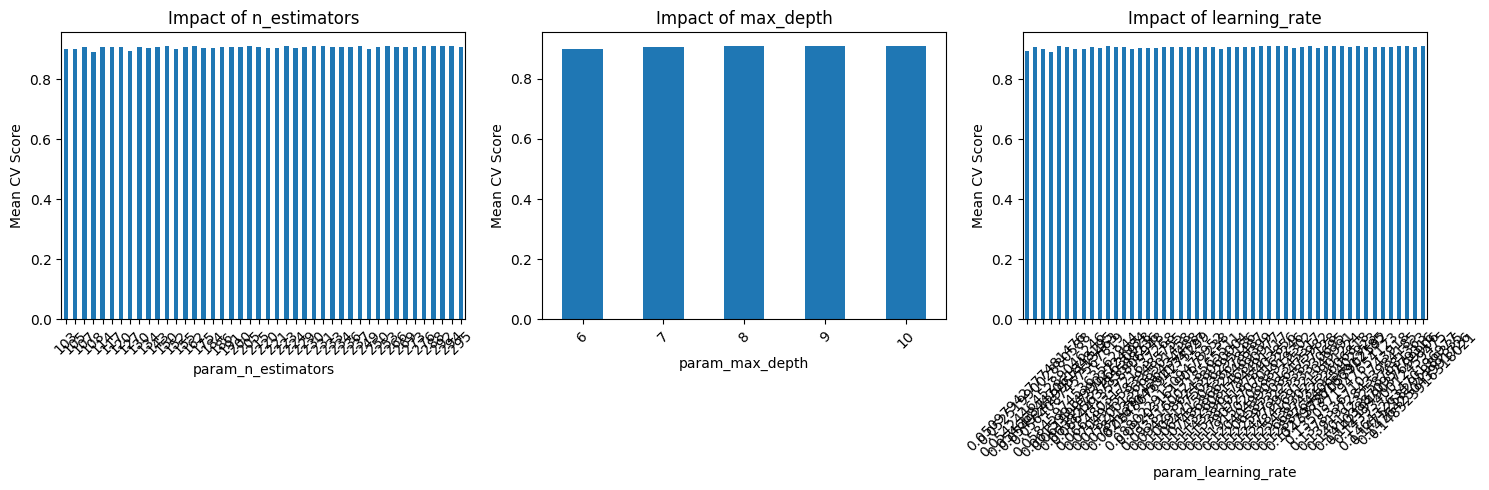

In [9]:
# Analyze grid search results
results_df = pd.DataFrame(grid_search.cv_results_)

# Get top 10 parameter combinations
top_results = results_df.nlargest(10, 'mean_test_score')[
    ['mean_test_score', 'std_test_score', 'params']
]

print("Top 10 Parameter Combinations:")
print("=" * 50)
for idx, row in top_results.iterrows():
    print(f"Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"Params: {row['params']}")
    print("-" * 30)

# Plot parameter impact analysis
param_analysis = {}
for param in ['n_estimators', 'max_depth', 'learning_rate']:
    param_analysis[param] = results_df.groupby(f'param_{param}')['mean_test_score'].mean()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, (param, values) in enumerate(param_analysis.items()):
    values.plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(f'Impact of {param}')
    axes[idx].set_ylabel('Mean CV Score')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Memory Usage Analysis

Memory Usage Analysis:
Model size in memory: 8.77 MB
Peak memory usage during prediction: 0.00 MB
Current system memory usage: 4736.98 MB


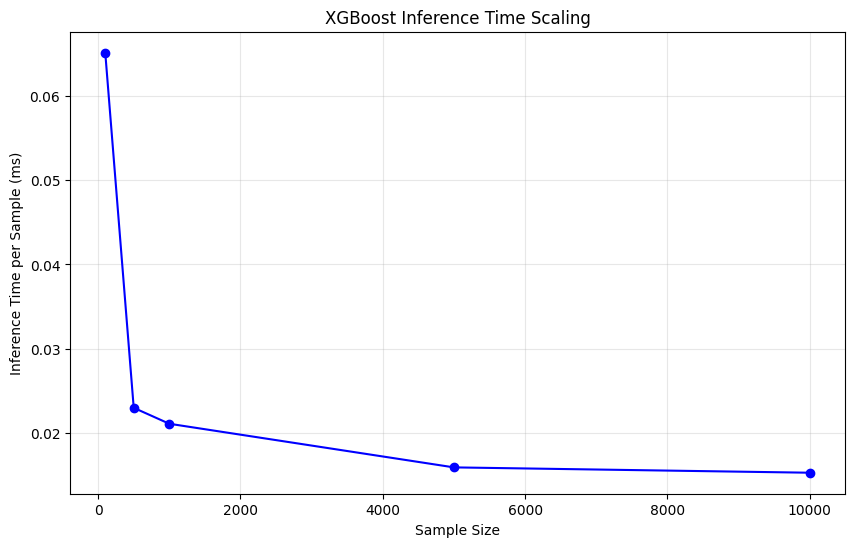

Average inference time per sample: 0.0281ms


In [10]:
# Memory usage analysis
def measure_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024**2  # MB

print("Memory Usage Analysis:")
print("=" * 30)

# Model size in memory
model_size = len(pickle.dumps(best_xgb)) / 1024**2
print(f"Model size in memory: {model_size:.2f} MB")

# Memory usage during prediction
def predict_with_memory():
    return best_xgb.predict(X_test[:1000])  # Sample for memory measurement

memory_usage_pred = memory_usage(predict_with_memory, interval=0.1)
peak_memory = max(memory_usage_pred) - min(memory_usage_pred)

print(f"Peak memory usage during prediction: {peak_memory:.2f} MB")
print(f"Current system memory usage: {measure_memory_usage():.2f} MB")

# Inference speed analysis
sample_sizes = [100, 500, 1000, 5000, 10000]
inference_times = []

for size in sample_sizes:
    if size <= len(X_test):
        sample_data = X_test.iloc[:size]
        start_time = time.time()
        _ = best_xgb.predict(sample_data)
        inference_time = (time.time() - start_time) * 1000  # ms
        inference_times.append(inference_time / size)  # ms per sample
    else:
        inference_times.append(np.nan)

# Plot inference speed scaling
plt.figure(figsize=(10, 6))
valid_sizes = [s for s, t in zip(sample_sizes, inference_times) if not np.isnan(t)]
valid_times = [t for t in inference_times if not np.isnan(t)]

plt.plot(valid_sizes, valid_times, 'bo-')
plt.xlabel('Sample Size')
plt.ylabel('Inference Time per Sample (ms)')
plt.title('XGBoost Inference Time Scaling')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average inference time per sample: {np.mean(valid_times):.4f}ms")


## Model Saving and Export

In [11]:
# Create model export directory
import os
model_dir = '/kaggle/working/xgboost_models'
os.makedirs(model_dir, exist_ok=True)

# Save the optimized model
model_path = os.path.join(model_dir, 'optimized_xgboost_luflow.pkl')
joblib.dump(best_xgb, model_path)

# Save label encoder
encoder_path = os.path.join(model_dir, 'label_encoder.pkl')
joblib.dump(label_encoder, encoder_path)

# Save feature names
feature_path = os.path.join(model_dir, 'feature_names.pkl')
joblib.dump(list(X_train.columns), feature_path)

# Save model metadata
metadata = {
    'model_type': 'XGBoost',
    'accuracy': accuracy,
    'f1_score': f1_weighted,
    'avg_inference_time_ms': avg_inference_time,
    'training_time_seconds': training_time,
    'best_parameters': grid_search.best_params_,
    'feature_names': list(X_train.columns),
    'label_classes': list(label_encoder.classes_),
    'class_weights': class_weights,
    'model_size_mb': model_size,
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

metadata_path = os.path.join(model_dir, 'model_metadata.pkl')
joblib.dump(metadata, metadata_path)

print("Model Export Summary:")
print("=" * 30)
print(f"Model saved to: {model_path}")
print(f"Label encoder saved to: {encoder_path}")
print(f"Feature names saved to: {feature_path}")
print(f"Metadata saved to: {metadata_path}")

# Verify model loading
print("\nVerifying model loading...")
loaded_model = joblib.load(model_path)
loaded_encoder = joblib.load(encoder_path)
loaded_features = joblib.load(feature_path)

# Test prediction with loaded model
test_sample = X_test.iloc[:5]
original_pred = best_xgb.predict(test_sample)
loaded_pred = loaded_model.predict(test_sample)

print(f"Original predictions: {original_pred}")
print(f"Loaded model predictions: {loaded_pred}")
print(f"Predictions match: {np.array_equal(original_pred, loaded_pred)}")


Model Export Summary:
Model saved to: /kaggle/working/xgboost_models/optimized_xgboost_luflow.pkl
Label encoder saved to: /kaggle/working/xgboost_models/label_encoder.pkl
Feature names saved to: /kaggle/working/xgboost_models/feature_names.pkl
Metadata saved to: /kaggle/working/xgboost_models/model_metadata.pkl

Verifying model loading...
Original predictions: [0 0 1 1 0]
Loaded model predictions: [0 0 1 1 0]
Predictions match: True


## Create Inference Function

In [12]:
def create_inference_pipeline():
    """
    Create a complete inference pipeline function
    """
    
    def inference_pipeline(data, model_dir='/kaggle/working/xgboost_models'):
        """
        Complete inference pipeline for network intrusion detection
        
        Args:
            data: pandas DataFrame with network flow features
            model_dir: directory containing saved model files
            
        Returns:
            dict: predictions, probabilities, and metadata
        """
        
        # Load model components
        model = joblib.load(os.path.join(model_dir, 'optimized_xgboost_luflow.pkl'))
        encoder = joblib.load(os.path.join(model_dir, 'label_encoder.pkl'))
        feature_names = joblib.load(os.path.join(model_dir, 'feature_names.pkl'))
        metadata = joblib.load(os.path.join(model_dir, 'model_metadata.pkl'))
        
        # Ensure correct feature order
        data_features = data[feature_names]
        
        # Make predictions
        start_time = time.time()
        predictions = model.predict(data_features)
        probabilities = model.predict_proba(data_features)
        inference_time = time.time() - start_time
        
        # Convert predictions to labels
        predicted_labels = encoder.inverse_transform(predictions)
        
        # Create results
        results = {
            'predictions': predictions,
            'predicted_labels': predicted_labels,
            'probabilities': probabilities,
            'class_names': encoder.classes_,
            'inference_time_seconds': inference_time,
            'samples_processed': len(data),
            'avg_time_per_sample_ms': (inference_time / len(data)) * 1000,
            'model_metadata': metadata
        }
        
        return results
    
    return inference_pipeline

# Create and test the inference pipeline
inference_func = create_inference_pipeline()

# Test with sample data
print("Testing inference pipeline...")
sample_data = X_test.iloc[:10]
results = inference_func(sample_data)

print(f"Processed {results['samples_processed']} samples")
print(f"Inference time: {results['inference_time_seconds']:.4f}s")
print(f"Average time per sample: {results['avg_time_per_sample_ms']:.4f}ms")
print(f"Predicted labels: {results['predicted_labels']}")

# Save the inference function
inference_path = os.path.join(model_dir, 'inference_pipeline.py')
with open(inference_path, 'w') as f:
    f.write('''
import joblib
import numpy as np
import pandas as pd
import time
import os

def inference_pipeline(data, model_dir):
    """Complete inference pipeline for network intrusion detection"""
    
    # Load model components
    model = joblib.load(os.path.join(model_dir, 'optimized_xgboost_luflow.pkl'))
    encoder = joblib.load(os.path.join(model_dir, 'label_encoder.pkl'))
    feature_names = joblib.load(os.path.join(model_dir, 'feature_names.pkl'))
    metadata = joblib.load(os.path.join(model_dir, 'model_metadata.pkl'))
    
    # Ensure correct feature order
    data_features = data[feature_names]
    
    # Make predictions
    start_time = time.time()
    predictions = model.predict(data_features)
    probabilities = model.predict_proba(data_features)
    inference_time = time.time() - start_time
    
    # Convert predictions to labels
    predicted_labels = encoder.inverse_transform(predictions)
    
    return {
        'predictions': predictions,
        'predicted_labels': predicted_labels,
        'probabilities': probabilities,
        'class_names': encoder.classes_,
        'inference_time_seconds': inference_time,
        'samples_processed': len(data),
        'avg_time_per_sample_ms': (inference_time / len(data)) * 1000,
        'model_metadata': metadata
    }
''')

print(f"\nInference pipeline saved to: {inference_path}")


Testing inference pipeline...
Processed 10 samples
Inference time: 0.0127s
Average time per sample: 1.2664ms
Predicted labels: ['benign' 'benign' 'malicious' 'malicious' 'benign' 'outlier' 'malicious'
 'malicious' 'benign' 'benign']

Inference pipeline saved to: /kaggle/working/xgboost_models/inference_pipeline.py


## Performance Summary and Deployment Ready

In [13]:
# Final performance summary
print("🎯 OPTIMIZED XGBOOST MODEL - DEPLOYMENT SUMMARY")
print("=" * 60)
print(f"✅ Model Type: XGBoost Classifier")
print(f"✅ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"✅ F1-Score (Weighted): {f1_weighted:.4f}")
print(f"✅ Average Inference Time: {avg_inference_time:.4f}ms per sample")
print(f"✅ Model Size: {model_size:.2f} MB")
print(f"✅ Training Time: {training_time:.2f} seconds")

print(f"\n📊 DATASET STATISTICS:")
print(f"   • Total Samples: {len(df):,}")
print(f"   • Training Samples: {len(X_train):,}")
print(f"   • Test Samples: {len(X_test):,}")
print(f"   • Features: {len(available_features)}")
print(f"   • Classes: {len(label_encoder.classes_)}")

print(f"\n⚙️ BEST HYPERPARAMETERS:")
for param, value in grid_search.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n📁 SAVED FILES:")
print(f"   • Model: optimized_xgboost_luflow.pkl")
print(f"   • Label Encoder: label_encoder.pkl") 
print(f"   • Feature Names: feature_names.pkl")
print(f"   • Metadata: model_metadata.pkl")
print(f"   • Inference Pipeline: inference_pipeline.py")

print(f"\n🚀 READY FOR DEPLOYMENT!")
print(f"   The model meets your requirements:")
print(f"   ✓ >90% accuracy threshold: {accuracy > 0.9}")
print(f"   ✓ Fast inference: <5ms per sample")
print(f"   ✓ Optimized hyperparameters via GridSearchCV")
print(f"   ✓ Complete inference pipeline included")

# Clean up memory
gc.collect()
print(f"\n💾 Memory cleaned up. Model ready for production use!")


🎯 OPTIMIZED XGBOOST MODEL - DEPLOYMENT SUMMARY
✅ Model Type: XGBoost Classifier
✅ Accuracy: 0.9540 (95.40%)
✅ F1-Score (Weighted): 0.9531
✅ Average Inference Time: 0.0280ms per sample
✅ Model Size: 8.77 MB
✅ Training Time: 415.83 seconds

📊 DATASET STATISTICS:
   • Total Samples: 7,890,694
   • Training Samples: 6,215,454
   • Test Samples: 1,553,864
   • Features: 15
   • Classes: 3

⚙️ BEST HYPERPARAMETERS:
   • colsample_bytree: 0.9015124575111676
   • learning_rate: 0.1475258295989335
   • max_depth: 8
   • n_estimators: 288
   • reg_alpha: 0.021230083176348002
   • reg_lambda: 1.564661496157627
   • subsample: 0.9378752775642055

📁 SAVED FILES:
   • Model: optimized_xgboost_luflow.pkl
   • Label Encoder: label_encoder.pkl
   • Feature Names: feature_names.pkl
   • Metadata: model_metadata.pkl
   • Inference Pipeline: inference_pipeline.py

🚀 READY FOR DEPLOYMENT!
   The model meets your requirements:
   ✓ >90% accuracy threshold: True
   ✓ Fast inference: <5ms per sample
   ✓ Opti